# Descripción de los datos
- Cada entrada de registro es una acción de usuario o un evento.

### EventName: nombre del evento.
### DeviceIDHash: identificador de usuario unívoco.
### EventTimestamp: hora del evento.
### ExpId: número de experimento: 246 y 247 son los grupos de control, 248 es el grupo de prueba.

## Paso 1. Abrir el archivo de datos y leer la información general


## Paso 2. Preparar los datos para el análisis
- Cambia el nombre de las columnas de manera que sea conveniente para ti
- Comprueba si hay tipos de datos y valores ausentes. Corrige los datos si es necesario
- Agrega una columna de fecha y hora y una columna separada para las fechas

## Paso 3. Estudiar y comprobar los datos

- ¿Cuántos eventos hay en los registros?
- ¿Cuántos usuarios y usuarias hay en los registros?
- ¿Cuál es el promedio de eventos por usuario?
- ¿Qué periodo de tiempo cubren los datos? Encuentra la fecha máxima y mínima. Traza un histograma por fecha y hora. ¿Puedes tener seguridad de que tienes datos igualmente completos para todo el periodo? Los eventos más antiguos podrían terminar en los registros de algunos usuarios o usuarias por razones técnicas y esto podría sesgar el panorama general. Encuentra el momento en el que los datos comienzan a estar completos e ignora la sección anterior. ¿Qué periodo representan realmente los datos?
- ¿Perdiste muchos eventos y usuarios al excluir los datos más antiguos?
- Asegúrate de tener usuarios y usuarias de los tres grupos experimentales.

## Paso 4. Estudiar el embudo de eventos

- Observa qué eventos hay en los registros y su frecuencia de suceso. Ordénalos por frecuencia.
- Encuentra la cantidad de usuarios y usuarias que realizaron cada una de estas acciones. Ordena los eventos por el número de usuarios y usuarias. Calcula la proporción de usuarios y usuarias que realizaron la acción al menos una vez.
- ¿En qué orden crees que ocurrieron las acciones? ¿Todas son parte de una sola secuencia? No es necesario tenerlas en cuenta al calcular el embudo.
- Utiliza el embudo de eventos para encontrar la proporción de usuarios y usuarias que pasan de una etapa a la siguiente. (Por ejemplo, para la secuencia de eventos A → B → C, calcula la proporción de usuarios en la etapa B a la cantidad de usuarios en la etapa A y la proporción de usuarios en la etapa C a la cantidad en la etapa B).
- ¿En qué etapa pierdes más usuarios y usuarias?
- ¿Qué porcentaje de usuarios y usuarias hace todo el viaje desde su primer evento hasta el pago?

## Paso 5. Estudiar los resultados del experimento

- ¿Cuántos usuarios y usuarias hay en cada grupo?
- Tenemos dos grupos de control en el test A/A, donde comprobamos nuestros mecanismos y cálculos. Observa si hay una diferencia estadísticamente significativa entre las muestras 246 y 247.
- Selecciona el evento más popular. En cada uno de los grupos de control, encuentra la cantidad de usuarios y usuarias que realizaron esta acción. Encuentra su proporción. Comprueba si la diferencia entre los grupos es estadísticamente significativa. Repite el procedimiento para todos los demás eventos (ahorrarás tiempo si creas una función especial para esta prueba). ¿Puedes confirmar que los grupos se dividieron correctamente?
- Haz lo mismo para el grupo con fuentes alteradas. Compara los resultados con los de cada uno de los grupos de control para cada evento de forma aislada. Compara los resultados con los resultados combinados de los grupos de control. ¿Qué conclusiones puedes sacar del experimento?
- ¿Qué nivel de significación has establecido para probar las hipótesis estadísticas mencionadas anteriormente? Calcula cuántas pruebas de hipótesis estadísticas has realizado. Con un nivel de significancia estadística de 0.1, uno de cada 10 resultados podría ser falso. ¿Cuál debería ser el nivel de significación? Si deseas cambiarlo, vuelve a ejecutar los pasos anteriores y comprueba tus conclusiones.

## Paso 1. Abrir el archivo de datos y leer la información general

###  Ruta de archivo: /datasets/logs_exp_us.csv Descarga el dataset

In [105]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy import stats as st
from IPython.display import display
from scipy.stats import ttest_ind
from scipy.stats import shapiro
from datetime import datetime
import itertools

In [106]:
# Descargamos el archivo 
logs = pd.read_csv('logs_exp_us.csv',  delimiter='\t')

#Convertimos los encabezados en minusculas 
logs.columns = logs.columns.str.lower()
logs

,eventname,deviceidhash,eventtimestamp,expid
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


## Paso 2. Preparar los datos para el análisis

### - Cambia el nombre de las columnas de manera que sea conveniente para ti
### - Comprueba si hay tipos de datos y valores ausentes. Corrige los datos si es necesario
### - Agrega una columna de fecha y hora y una columna separada para las fechas

In [107]:
# Cambiar nombres de columnas específicos
logs = logs.rename(columns={'eventname': 'evento', 'deviceidhash': 'identificador_usuario', 'eventtimestamp': 'fecha', 'expid': 'numero_grupo'})

In [108]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   evento                 244126 non-null  object
 1   identificador_usuario  244126 non-null  int64 
 2   fecha                  244126 non-null  int64 
 3   numero_grupo           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [109]:
# Convierte la columna 'fecha' de timestamp a datetime
logs['fecha'] = pd.to_datetime(logs['fecha'], unit='s')

# Extrae solo la fecha
logs['date'] = logs['fecha'].dt.date

# Extrae solo la hora en formato 'HH:MM:SS'
logs['hora'] = logs['fecha'].dt.strftime('%H:%M:%S')

# Verifica el resultado
logs[['fecha', 'date', 'hora']].head()


,fecha,date,hora
0,2019-07-25 04:43:36,2019-07-25,04:43:36
1,2019-07-25 11:11:42,2019-07-25,11:11:42
2,2019-07-25 11:28:47,2019-07-25,11:28:47
3,2019-07-25 11:28:47,2019-07-25,11:28:47
4,2019-07-25 11:48:42,2019-07-25,11:48:42


In [110]:
# Verificamos si no hay valores nulos y los sumamos
display(logs.isnull().sum())

evento                   0
identificador_usuario    0
fecha                    0
numero_grupo             0
date                     0
hora                     0
dtype: int64

No hay valores nulos

In [111]:
# Asegúrate de que 'date' esté en formato datetime
logs['date'] = pd.to_datetime(logs['date']).dt.normalize()



In [112]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   evento                 244126 non-null  object        
 1   identificador_usuario  244126 non-null  int64         
 2   fecha                  244126 non-null  datetime64[ns]
 3   numero_grupo           244126 non-null  int64         
 4   date                   244126 non-null  datetime64[ns]
 5   hora                   244126 non-null  object        
dtypes: datetime64[ns](2), int64(2), object(2)
memory usage: 11.2+ MB


In [113]:
logs

,evento,identificador_usuario,fecha,numero_grupo,date,hora
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25,04:43:36
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25,11:11:42
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,11:28:47
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,11:28:47
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25,11:48:42
...,...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07,21:12:25
244122,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07,21:13:59
244123,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07,21:14:43
244124,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07,21:14:58


## Paso 3. Estudiar y comprobar los datos

- 3.1 ¿Cuántos eventos hay en los registros?
- 3.2 ¿Cuántos usuarios y usuarias hay en los registros?
- 3.3 ¿Cuál es el promedio de eventos por usuario?
- 3.4 ¿Qué periodo de tiempo cubren los datos? Encuentra la fecha máxima y mínima. Traza un histograma por fecha y hora. ¿Puedes tener seguridad de que tienes datos igualmente completos para todo el periodo? Los eventos más antiguos podrían terminar en los registros de algunos usuarios o usuarias por razones técnicas y esto podría sesgar el panorama general. Encuentra el momento en el que los datos comienzan a estar completos e ignora la sección anterior. ¿Qué periodo representan realmente los datos?
- 3.5 ¿Perdiste muchos eventos y usuarios al excluir los datos más antiguos?

Asegúrate de tener usuarios y usuarias de los tres grupos experimentales.

### 3.1 ¿Cuántos eventos hay en los registros?

In [114]:
# Conteo de cada evento registrado
logs['evento'].value_counts()

evento
MainScreenAppear           119205
OffersScreenAppear          46825
CartScreenAppear            42731
PaymentScreenSuccessful     34313
Tutorial                     1052
Name: count, dtype: int64

In [115]:
# Conteo de todos los eventos juntos
total_eventos = logs['evento'].count()
total_eventos

np.int64(244126)

### 3.2 ¿Cuántos eventos hay en los registros?

In [116]:
total_usuarios = logs['identificador_usuario'].nunique()
total_usuarios

7551

### 3.3 ¿Cuál es el promedio de eventos por usuario?

In [117]:
promedio_eventos_por_usuario = logs['evento'].count() / logs['identificador_usuario'].nunique()
promedio_eventos_por_usuario

np.float64(32.33028737915508)

### 3.4 ¿Qué periodo de tiempo cubren los datos?
### Encuentra la fecha máxima y mínima. Traza un histograma por fecha y hora. 
### ¿Puedes tener seguridad de que tienes datos igualmente completos para todo el periodo?
### Los eventos más antiguos podrían terminar en los registros de algunos usuarios o usuarias por razones técnicas y esto podría sesgar el panorama general.
### Encuentra el momento en el que los datos comienzan a estar completos e ignora la sección anterior.
### ¿Qué periodo representan realmente los datos?

In [118]:
# Obtener la fecha mínima y máxima
fecha_minima = logs['fecha'].min()
fecha_maxima = logs['fecha'].max()

display(f"El periodo de tiempo cubierto por los datos es desde {fecha_minima} hasta {fecha_maxima}.")

'El periodo de tiempo cubierto por los datos es desde 2019-07-25 04:43:36 hasta 2019-08-07 21:15:17.'

In [119]:
logs

,evento,identificador_usuario,fecha,numero_grupo,date,hora
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25,04:43:36
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25,11:11:42
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,11:28:47
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,11:28:47
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25,11:48:42
...,...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07,21:12:25
244122,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07,21:13:59
244123,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07,21:14:43
244124,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07,21:14:58


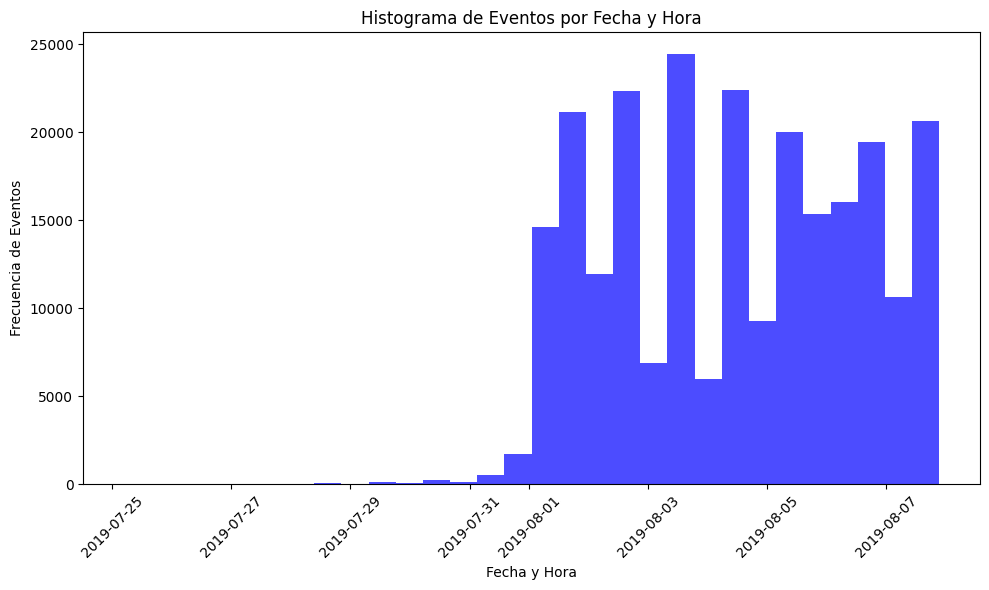

In [120]:
# Crear una nueva variable que combine 'date' y 'hora'
fecha_hora = pd.to_datetime(logs['date'].astype(str) + ' ' + logs['hora'])

# Trazar el histograma
plt.figure(figsize=(10, 6))
plt.hist(fecha_hora, bins=30, color='blue', alpha=0.7)
plt.title('Histograma de Eventos por Fecha y Hora')
plt.xlabel('Fecha y Hora')
plt.ylabel('Frecuencia de Eventos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Grafica que muestra la frecuencia de eventos por fecha y hora entre el 25 de julio y el 7 de agosto de 2019. 

- Se aprecia un aumento gradual en la frecuencia de eventos a partir del 30 de julio de 2019.
- La frecuencia máxima de eventos se alcanza entre el 2 y el 3 de agosto, con un pico de aproximadamente 25,000 eventos.
- Después de este pico, la frecuencia de eventos muestra una disminución seguida de fluctuaciones significativas.

In [121]:
logs

,evento,identificador_usuario,fecha,numero_grupo,date,hora
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25,04:43:36
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25,11:11:42
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,11:28:47
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,11:28:47
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25,11:48:42
...,...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07,21:12:25
244122,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07,21:13:59
244123,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07,21:14:43
244124,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07,21:14:58


### ¿Puedes tener seguridad de que tienes datos igualmente completos para todo el periodo?

In [122]:
# Agrupa el Df y luego contamos el numero de eventos 
conteo_por_dia = logs.groupby('date').size()
conteo_por_dia

date
2019-07-25        9
2019-07-26       31
2019-07-27       55
2019-07-28      105
2019-07-29      184
2019-07-30      413
2019-07-31     2031
2019-08-01    36229
2019-08-02    35606
2019-08-03    33351
2019-08-04    33033
2019-08-05    36113
2019-08-06    35822
2019-08-07    31144
dtype: int64

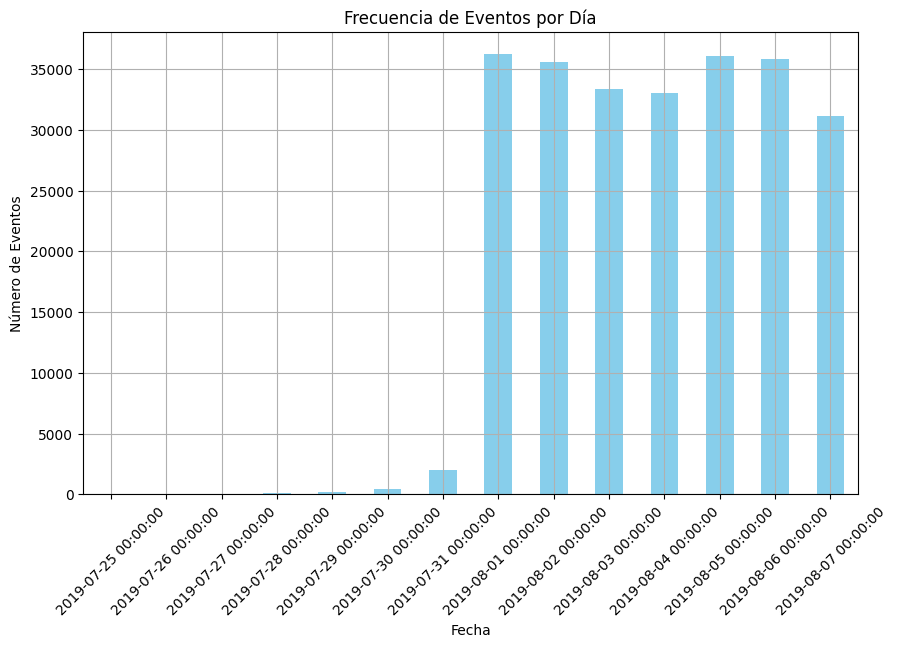

In [123]:
# Graficamos el comportamiento de los datos de la tabla logs
plt.figure(figsize=(10, 6))
conteo_por_dia.plot(kind='bar', color='skyblue')
plt.title("Frecuencia de Eventos por Día")
plt.xlabel("Fecha")
plt.ylabel("Número de Eventos")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Basándonos en la gráfica de frecuencia de eventos por día, podemos observar lo siguiente:

- Período con baja frecuencia de eventos: Desde el 25 de julio hasta el 31 de julio de 2019, el número de eventos es extremadamente bajo en comparación con los días posteriores. Esto sugiere que los datos en esta primera parte del periodo están incompletos o presentan lagunas significativas.

- Período con alta frecuencia de eventos: A partir del 1 de agosto de 2019, la cantidad de eventos por día aumenta considerablemente y se mantiene relativamente constante hasta el 7 de agosto de 2019. Este patrón indica que los datos para este periodo son consistentes y completos en comparación con los días anteriores.

- Conclusión: No podemos asegurar que los datos estén igualmente completos para todo el periodo, ya que existe una clara discrepancia en la cantidad de eventos entre los primeros días y los días posteriores. Esta variación sugiere que el análisis de comportamiento de usuario podría estar sesgado si se incluye el periodo inicial, ya que no refleja la misma densidad de datos que el resto del conjunto.

Por lo tanto, sería recomendable sugerir enfocar el análisis principal en el periodo desde el 1 de agosto en adelante, donde los datos parecen ser más completos y consistentes.

### Los eventos más antiguos podrían terminar en los registros de algunos usuarios o usuarias por razones técnicas y esto podría sesgar el panorama general. 

In [124]:
# Convertimos la columna 'date' a formato de fecha, si no lo está ya
logs['date'] = pd.to_datetime(logs['date'])

# Filtramos el DataFrame para incluir solo los eventos desde el 1 de agosto de 2019
clean_logs = logs[logs['date'] >= '2019-08-01']

# Verificamos el resultado
clean_logs.head()
display(f"Número de eventos después de limpiar el periodo incompleto: {clean_logs.shape[0]}")

'Número de eventos después de limpiar el periodo incompleto: 241298'

In [125]:
# Nos aseguramos de la limpieza
conteo_clean_logs = clean_logs.groupby('date').size()
conteo_clean_logs

date
2019-08-01    36229
2019-08-02    35606
2019-08-03    33351
2019-08-04    33033
2019-08-05    36113
2019-08-06    35822
2019-08-07    31144
dtype: int64

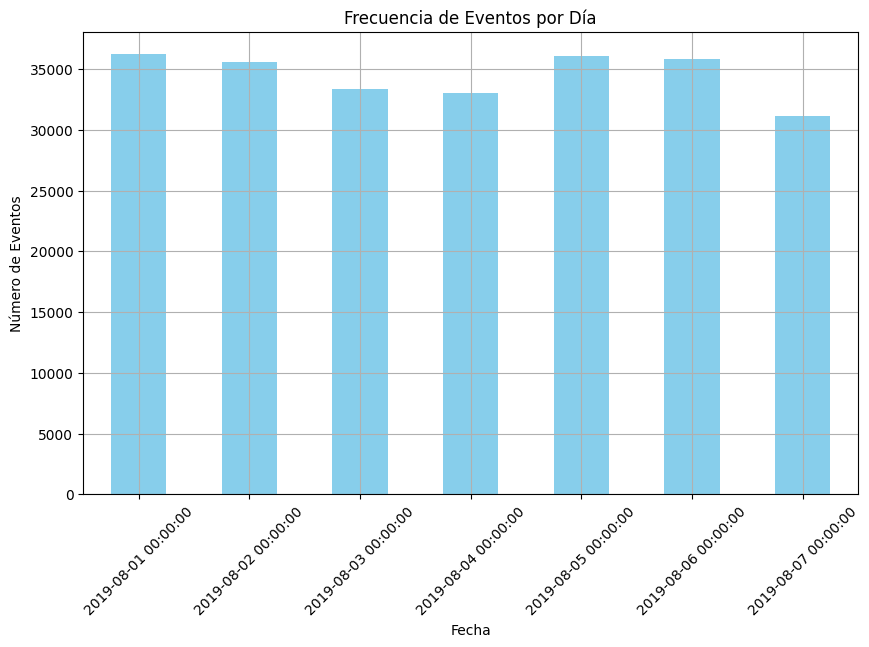

In [126]:
# Graficamos los datos 
plt.figure(figsize=(10, 6))
conteo_clean_logs.plot(kind='bar', color='skyblue')
plt.title("Frecuencia de Eventos por Día")
plt.xlabel("Fecha")
plt.ylabel("Número de Eventos")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

 ### Los datos realmente representan de manera consistente el periodo del 1 de agosto de 2019 al 7 de agosto de 2019. 
 - Este es el rango en el que vemos una cantidad significativa y relativamente estable de eventos por día, indicando que los datos están completos y pueden ser utilizados para un análisis confiable.

- El periodo anterior, del 25 de julio al 31 de julio de 2019, tiene muy pocos eventos registrados, lo que sugiere que los datos para esos días están incompletos y podrían no ser representativos del comportamiento de usuario en general.

## 3.5 ¿Perdiste muchos eventos y usuarios al excluir los datos más antiguos?

In [127]:
# Contar eventos y usuarios en el DataFrame original
total_eventos_original = logs.shape[0]
total_usuarios_original = logs['identificador_usuario'].nunique()

# Contar eventos y usuarios en el DataFrame filtrado
total_eventos_filtrados = clean_logs.shape[0]
total_usuarios_filtrados = clean_logs['identificador_usuario'].nunique()

# Mostrar resultados
print(f"Número total de eventos originales: {total_eventos_original}")
print(f"Número total de usuarios originales: {total_usuarios_original}")
print(f"Número total de eventos después del filtro: {total_eventos_filtrados}")
print(f"Número total de usuarios después del filtro: {total_usuarios_filtrados}")

# Calcular las pérdidas
eventos_perdidos = total_eventos_original - total_eventos_filtrados
usuarios_perdidos = total_usuarios_original - total_usuarios_filtrados

print(f"Eventos perdidos al excluir datos más antiguos: {eventos_perdidos}")
print(f"Usuarios perdidos al excluir datos más antiguos: {usuarios_perdidos}")

Número total de eventos originales: 244126
Número total de usuarios originales: 7551
Número total de eventos después del filtro: 241298
Número total de usuarios después del filtro: 7534
Eventos perdidos al excluir datos más antiguos: 2828
Usuarios perdidos al excluir datos más antiguos: 17


## Análisis de Pérdida de Eventos y Usuarios tras la Exclusión de Datos Más Antiguos

Después de aplicar el filtro que excluye los datos más antiguos, se realizó un análisis comparativo entre el conjunto de datos original y el conjunto filtrado. 

Los resultados son los siguientes:

- Número total de eventos originales: 244,126
- Número total de usuarios originales: 7,551

### Tras la aplicación del filtro, los números cambiaron a:

#### - Número total de eventos después del filtro: 241,298
#### - Número total de usuarios después del filtro: 7,534

## 3.6 Asegúrate de tener usuarios y usuarias de los tres grupos experimentales.

In [128]:
# Verificar los grupos experimentales en clean_logs
grupos_experimentales = clean_logs['numero_grupo'].unique()
print(f"Grupos experimentales identificados en clean_logs: {grupos_experimentales}")

# Contar usuarios únicos en cada grupo de clean_logs
usuarios_por_grupo = clean_logs.groupby('numero_grupo')['identificador_usuario'].nunique()

# Mostrar el conteo de usuarios por grupo
print("Número de usuarios por grupo experimental en clean_logs:")
print(usuarios_por_grupo)

# Verificar si hay usuarios en los tres grupos
grupos_con_usuarios = usuarios_por_grupo[usuarios_por_grupo > 0]

if len(grupos_con_usuarios) == 3:
    print("Todos los grupos experimentales tienen usuarios en clean_logs.")
else:
    print("Faltan grupos experimentales con usuarios en clean_logs.")


Grupos experimentales identificados en clean_logs: [246 247 248]
Número de usuarios por grupo experimental en clean_logs:
numero_grupo
246    2484
247    2513
248    2537
Name: identificador_usuario, dtype: int64
Todos los grupos experimentales tienen usuarios en clean_logs.


### Análisis de Usuarios por Grupo Experimental en clean_logs

Se identificaron los siguientes grupos experimentales en el conjunto de datos clean_logs: 246, 247 y 248. A continuación, se detalla el número de usuarios únicos registrados en cada uno de estos grupos:

#### Grupo 246: 2,484 usuarios
#### Grupo 247: 2,513 usuarios
#### Grupo 248: 2,537 usuarios

Estos resultados sugieren que todos los grupos experimentales están representados en el conjunto de datos.

## Paso 4. Estudiar el embudo de eventos

#### - 4.1 Observa qué eventos hay en los registros y su frecuencia de suceso. Ordénalos por frecuencia.
#### - 4.2 Encuentra la cantidad de usuarios y usuarias que realizaron cada una de estas acciones. Ordena los eventos por el número de usuarios y usuarias. Calcula la proporción de usuarios y usuarias que realizaron la acción al menos una vez.
#### - 4.3 ¿En qué orden crees que ocurrieron las acciones? ¿Todas son parte de una sola secuencia? No es necesario tenerlas en cuenta al calcular el embudo.
#### - 4.5 Utiliza el embudo de eventos para encontrar la proporción de usuarios y usuarias que pasan de una etapa a la siguiente. (Por ejemplo, para la secuencia de eventos A → B → C, calcula la proporción de usuarios en la etapa B a la cantidad de usuarios en la etapa A y la proporción de usuarios en la etapa C a la cantidad en la etapa B).
#### - 4.6 ¿En qué etapa pierdes más usuarios y usuarias?
#### - 4.7¿Qué porcentaje de usuarios y usuarias hace todo el viaje desde su primer evento hasta el pago?

## 4.1 Observa qué eventos hay en los registros y su frecuencia de suceso. Ordénalos por frecuencia.

In [129]:
# Contar la frecuencia de cada evento en clean_logs
frecuencia_eventos = clean_logs['evento'].value_counts()

# Ordenar los eventos por frecuencia (ya está ordenado por defecto)
frecuencia_eventos = frecuencia_eventos.sort_values(ascending=False)

frecuencia_eventos

evento
MainScreenAppear           117431
OffersScreenAppear          46350
CartScreenAppear            42365
PaymentScreenSuccessful     34113
Tutorial                     1039
Name: count, dtype: int64

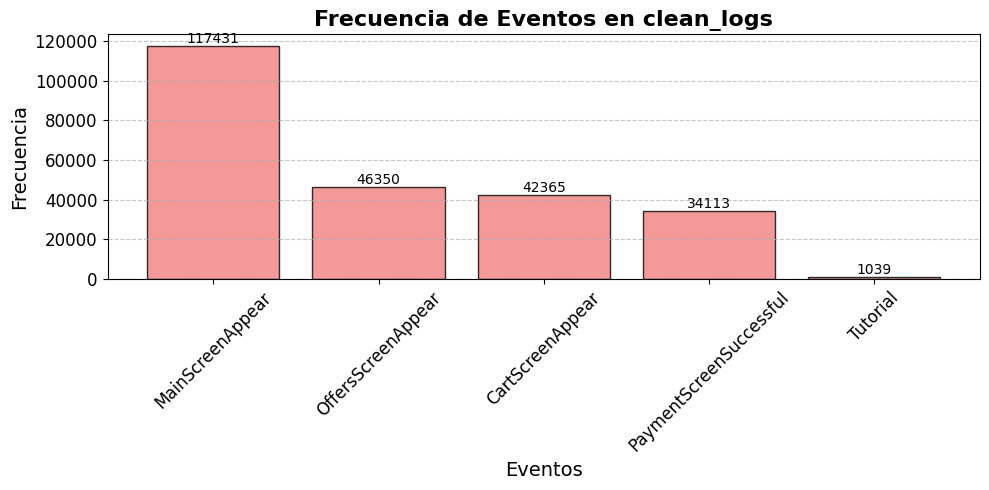

In [130]:
# Graficar la frecuencia de eventos
plt.figure(figsize=(10, 5))
bars = plt.bar(frecuencia_eventos.index.astype(str), frecuencia_eventos.values, color='lightcoral', edgecolor='black', alpha=0.8)

# Agregar título y etiquetas
plt.title('Frecuencia de Eventos en clean_logs', fontsize=16, fontweight='bold')
plt.xlabel('Eventos', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)

# Agregar etiquetas de frecuencia encima de cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center', fontsize=10)

# Mejorar la apariencia del gráfico
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Mostrar el gráfico
plt.show()

**Conclusion:** Este gráfico sugiere que la mayoría de los usuarios interactúan principalmente con la pantalla principal y pasan por otras pantallas como ofertas y carrito, pero no todos completan el proceso de pago. La baja frecuencia del evento Tutorial podría ser un área de oportunidad para mejorar la accesibilidad o visibilidad del tutorial si es relevante para el onboarding de nuevos usuarios.

## 4.2 Encuentra la cantidad de usuarios y usuarias que realizaron cada una de estas acciones. Ordena los eventos por el número de usuarios y usuarias. Calcula la proporción de usuarios y usuarias que realizaron la acción al menos una vez.

In [131]:
# Total de usuarios únicos en clean_logs
total_usuarios = clean_logs['identificador_usuario'].nunique()
# Contar la cantidad de usuarios únicos por cada evento
usuarios_por_evento = clean_logs.groupby('evento')['identificador_usuario'].nunique()
# Calcular la proporción de usuarios que realizaron cada evento al menos una vez
proporcion_usuarios_por_evento = (usuarios_por_evento / total_usuarios) * 100
# Ordenar de mayor a menor proporción
proporcion_usuarios_por_evento = proporcion_usuarios_por_evento.sort_values(ascending=False)

proporcion_usuarios_por_evento

evento
MainScreenAppear           98.473586
OffersScreenAppear         60.963632
CartScreenAppear           49.561986
PaymentScreenSuccessful    46.973719
Tutorial                   11.149456
Name: identificador_usuario, dtype: float64

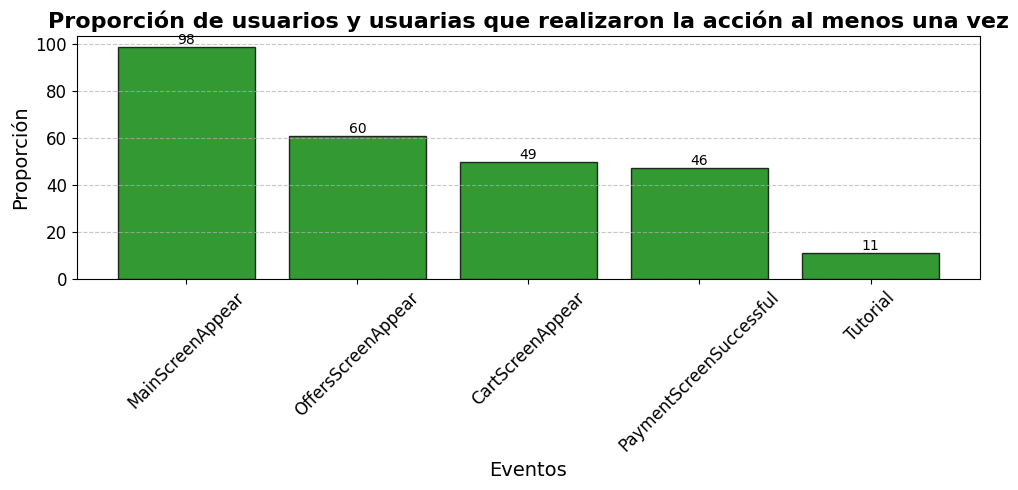

In [132]:
# Graficar la frecuencia de eventos
plt.figure(figsize=(10, 5))
bars = plt.bar(proporcion_usuarios_por_evento.index.astype(str), proporcion_usuarios_por_evento.values, color='green', edgecolor='black', alpha=0.8)

# Agregar título y etiquetas
plt.title('Proporción de usuarios y usuarias que realizaron la acción al menos una vez', fontsize=16, fontweight='bold')
plt.xlabel('Eventos', fontsize=14)
plt.ylabel('Proporción', fontsize=14)

# Agregar etiquetas de frecuencia encima de cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center', fontsize=10)

# Mejorar la apariencia del gráfico
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Mostrar el gráfico
plt.show()

#### Los resultados del análisis indican lo siguiente:

- **MainScreenAppear:** Es la acción más común, con un 98.47% de los usuarios únicos accediendo a la pantalla principal al menos una vez. Esto sugiere que casi todos los usuarios interactúan con la pantalla principal, lo cual es coherente con la expectativa de que sea el primer punto de interacción en la aplicación.

- **OffersScreenAppear:** El 60.96% de los usuarios accedieron a la pantalla de ofertas al menos una vez, lo que muestra un interés considerable en explorar las promociones o descuentos disponibles.

- **CartScreenAppear:** Aproximadamente 49.56% de los usuarios avanzaron al carrito de compras, lo que indica que casi la mitad de los usuarios están añadiendo productos y evaluando la posibilidad de realizar una compra.

- **PaymentScreenSuccessful:** Un 46.97% de los usuarios completaron el proceso de pago con éxito, lo cual es una proporción alta respecto al número de usuarios que llegaron al carrito, sugiriendo una conversión relativamente eficiente entre estos pasos.

- **Tutorial:** Solo el 11.15% de los usuarios interactuaron con el tutorial, lo que podría implicar que la mayoría de los usuarios omiten este paso o que no consideran necesario utilizarlo.


## 4.3 ¿En qué orden crees que ocurrieron las acciones? 
- El orden probable de las acciones es: **MainScreenAppear** → **OffersScreenAppear** → **CartScreenAppear** → **PaymentScreenSuccessful**, con el Tutorial ocurriendo de forma independiente o al inicio para ciertos usuarios.
## ¿Todas son parte de una sola secuencia? 
No, no todas las acciones parecen ser parte de una única secuencia lineal de uso. Basándonos en los datos, se puede observar lo siguiente:

- **MainScreenAppear, OffersScreenAppear, CartScreenAppear y PaymentScreenSuccessful** están alineados con un flujo de compra típico en una aplicación de comercio electrónico. Los usuarios comienzan en la pantalla principal, revisan las ofertas, agregan productos al carrito y luego proceden al pago.
- Tutorial, por otro lado, no parece seguir la misma secuencia que las otras acciones. Dado que solo el 11.15% de los usuarios interactuaron con él, es probable que el tutorial sea opcional o que los usuarios lo vean en contextos específicos (por ejemplo, cuando usan la aplicación por primera vez o buscan ayuda). Esto sugiere que el tutorial no es parte de la secuencia principal de acciones.

**Conclusión:**
Mientras que MainScreenAppear, OffersScreenAppear, CartScreenAppear y PaymentScreenSuccessful parecen formar una secuencia relacionada con el proceso de compra, el Tutorial es una acción separada y no es parte del flujo principal de la secuencia de compra.
### No es necesario tenerlas en cuenta al calcular el embudo.

## 4.4 Utiliza el embudo de eventos para encontrar la proporción de usuarios y usuarias que pasan de una etapa a la siguiente. (Por ejemplo, para la secuencia de eventos A → B → C, calcula la proporción de usuarios en la etapa B a la cantidad de usuarios en la etapa A y la proporción de usuarios en la etapa C a la cantidad en la etapa B).

In [133]:
# Filtrar por cada evento clave en el embudo
main_screen_users = clean_logs[clean_logs['evento'] == 'MainScreenAppear']['identificador_usuario'].nunique()
offers_screen_users = clean_logs[clean_logs['evento'] == 'OffersScreenAppear']['identificador_usuario'].nunique()
cart_screen_users = clean_logs[clean_logs['evento'] == 'CartScreenAppear']['identificador_usuario'].nunique()
payment_screen_users = clean_logs[clean_logs['evento'] == 'PaymentScreenSuccessful']['identificador_usuario'].nunique()

# Calcular las proporciones de transición entre eventos
proportion_offers_main = offers_screen_users / main_screen_users
proportion_cart_offers = cart_screen_users / offers_screen_users
proportion_payment_cart = payment_screen_users / cart_screen_users

# Mostrar los resultados
display("Proporción de usuarios que avanzan de MainScreenAppear a OffersScreenAppear:", proportion_offers_main)
display("Proporción de usuarios que avanzan de OffersScreenAppear a CartScreenAppear:", proportion_cart_offers)
display("Proporción de usuarios que avanzan de CartScreenAppear a PaymentScreenSuccessful:", proportion_payment_cart)



'Proporción de usuarios que avanzan de MainScreenAppear a OffersScreenAppear:'

0.6190861302062273

'Proporción de usuarios que avanzan de OffersScreenAppear a CartScreenAppear:'

0.8129762682342695

'Proporción de usuarios que avanzan de CartScreenAppear a PaymentScreenSuccessful:'

0.9477771826459561

## Resumen del Embudo de Conversión
Los resultados del embudo de conversión en la app indican lo siguiente:

- **MainScreenAppear → OffersScreenAppear:** El 61.91% de los usuarios que visitan la pantalla principal pasan a la pantalla de ofertas, lo cual muestra interés en explorar promociones, aunque un 38% no avanza.

- **OffersScreenAppear → CartScreenAppear:** El 81.30% de los usuarios que ven las ofertas añaden productos al carrito, lo que refleja que las promociones son atractivas para la mayoría.

- **CartScreenAppear → PaymentScreenSuccessful:** El 94.78% de los usuarios que llegan al carrito completan el pago, una alta tasa de conversión que indica una experiencia de compra efectiva.

#### Conclusión
El flujo de compra muestra una retención fuerte, especialmente en los pasos de compra y pago. La caída más notable ocurre entre la pantalla principal y la de ofertas, sugiriendo una oportunidad para mejorar la visibilidad de las ofertas desde la pantalla principal

## 4.5 ¿En qué etapa pierdes más usuarios y usuarias?

La etapa donde se pierden más usuarios es en la transición de **MainScreenAppear a OffersScreenAppear, con un 38.09%** de usuarios que no avanzan hacia la pantalla de ofertas. Esto significa que, aunque una mayoría explora la aplicación desde la pantalla principal, un número considerable de usuarios no pasa a la siguiente etapa del flujo de compra.

Esta pérdida de usuarios en la primera transición podría indicar que no todos encuentran atractivo explorar las ofertas o que los elementos de navegación hacia esta sección podrían mejorarse para fomentar la transición hacia la pantalla de ofertas.

## 4.6 ¿Qué porcentaje de usuarios y usuarias hace todo el viaje desde su primer evento hasta el pago?

In [134]:
# Total de usuarios que inician en MainScreenAppear
total_main_screen_users = clean_logs[clean_logs['evento'] == 'MainScreenAppear']['identificador_usuario'].nunique()

# Usuarios que completan todo el flujo hasta PaymentScreenSuccessful
completed_flow_users = clean_logs[(clean_logs['evento'] == 'MainScreenAppear') & 
                                  (clean_logs['identificador_usuario'].isin(
                                      clean_logs[clean_logs['evento'] == 'PaymentScreenSuccessful']['identificador_usuario'])
                                  )]['identificador_usuario'].nunique()

# Calcular el porcentaje
completion_percentage = (completed_flow_users / total_main_screen_users) * 100
completion_percentage


46.38091386979377

El **46.38%** de los usuarios completó todo el recorrido desde su primer evento en la pantalla principal hasta el pago exitoso. Esto sugiere que casi la mitad de los usuarios que iniciaron la interacción en la app avanzaron en cada etapa del flujo de compra y finalizaron el proceso.

Este porcentaje refleja un nivel de conversión relativamente alto, aunque también sugiere que existe margen de mejora en algunas etapas, especialmente al inicio, para aumentar la retención y guiar a más usuarios a través de todo el flujo hasta la compra final.

## Paso 5. Estudiar los resultados del experimento

- #### 5.1 ¿Cuántos usuarios y usuarias hay en cada grupo?
- #### 5.2 Tenemos dos grupos de control en el test A/A, donde comprobamos nuestros mecanismos y cálculos. Observa si hay una diferencia estadísticamente significativa entre las muestras 246 y 247.
- #### 5.3 Selecciona el evento más popular. En cada uno de los grupos de control, encuentra la cantidad de usuarios y usuarias que realizaron esta acción. Encuentra su proporción. Comprueba si la diferencia entre los grupos es estadísticamente significativa. Repite el procedimiento para todos los demás eventos (ahorrarás tiempo si creas una función especial para esta prueba). ¿Puedes confirmar que los grupos se dividieron correctamente?
- #### 5.4 Haz lo mismo para el grupo con fuentes alteradas. Compara los resultados con los de cada uno de los grupos de control para cada evento de forma aislada. Compara los resultados con los resultados combinados de los grupos de control. ¿Qué conclusiones puedes sacar del experimento?
- #### 5.5 ¿Qué nivel de significación has establecido para probar las hipótesis estadísticas mencionadas anteriormente? Calcula cuántas pruebas de hipótesis estadísticas has realizado. Con un nivel de significancia estadística de 0.1, uno de cada 10 resultados podría ser falso. ¿Cuál debería ser el nivel de significación? Si deseas cambiarlo, vuelve a ejecutar los pasos anteriores y comprueba tus conclusiones.


## 5.1 ¿Cuántos usuarios y usuarias hay en cada grupo?

In [135]:
# Contar usuarios únicos en cada grupo experimental
usuarios_por_grupo = clean_logs.groupby('numero_grupo')['identificador_usuario'].nunique()


usuarios_por_grupo


numero_grupo
246    2484
247    2513
248    2537
Name: identificador_usuario, dtype: int64

## 5.2 Tenemos dos grupos de control en el test A/A, donde comprobamos nuestros mecanismos y cálculos. Observa si hay una diferencia estadísticamente significativa entre las muestras 246 y 247.

In [145]:
# Extrae los datos y convierte a formato numérico (en segundos desde la fecha mínima)
tiempo_246 = clean_logs[(clean_logs['numero_grupo'] == 246) & 
                        (clean_logs['evento'] == 'MainScreenAppear')]['fecha'].dropna()
tiempo_247 = clean_logs[(clean_logs['numero_grupo'] == 247) & 
                        (clean_logs['evento'] == 'MainScreenAppear')]['fecha'].dropna()

# Convertir a segundos desde la fecha mínima
tiempo_246 = (tiempo_246 - tiempo_246.min()).dt.total_seconds()
tiempo_247 = (tiempo_247 - tiempo_247.min()).dt.total_seconds()

# Realiza la prueba de Shapiro-Wilk para el grupo 246
stat_246, p_value_246 = shapiro(tiempo_246)
print(f"Grupo 246 - Estadístico de Shapiro-Wilk: {stat_246}, Valor p: {p_value_246}")
if p_value_246 < 0.05:
    print("Grupo 246: Los datos no siguen una distribución normal.")
else:
    print("Grupo 246: Los datos parecen seguir una distribución normal.")

# Realiza la prueba de Shapiro-Wilk para el grupo 247
stat_247, p_value_247 = shapiro(tiempo_247)
print(f"Grupo 247 - Estadístico de Shapiro-Wilk: {stat_247}, Valor p: {p_value_247}")
if p_value_247 < 0.05:
    print("Grupo 247: Los datos no siguen una distribución normal.")
else:
    print("Grupo 247: Los datos parecen seguir una distribución normal.")


Grupo 246 - Estadístico de Shapiro-Wilk: 0.9467835615187427, Valor p: 4.7505241872547227e-76
Grupo 246: Los datos no siguen una distribución normal.
Grupo 247 - Estadístico de Shapiro-Wilk: 0.9424801435184658, Valor p: 1.5741089052411235e-78
Grupo 247: Los datos no siguen una distribución normal.


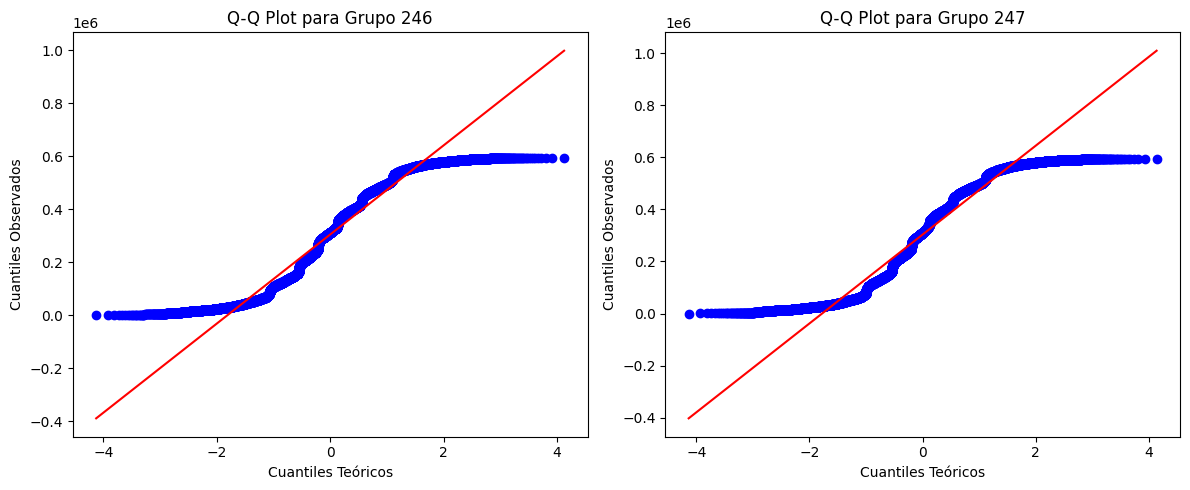

In [146]:
# Crear Q-Q plot para el grupo 246
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
stats.probplot(tiempo_246, dist="norm", plot=plt)
plt.title('Q-Q Plot para Grupo 246')
plt.xlabel('Cuantiles Teóricos')
plt.ylabel('Cuantiles Observados')

# Crear Q-Q plot para el grupo 247
plt.subplot(1, 2, 2)
stats.probplot(tiempo_247, dist="norm", plot=plt)
plt.title('Q-Q Plot para Grupo 247')
plt.xlabel('Cuantiles Teóricos')
plt.ylabel('Cuantiles Observados')

# Muestra el gráfico
plt.tight_layout()
plt.show()

In [ ]:
# Realiza la prueba de Mann-Whitney U para comparar los grupos 246 y 247
stat, p_value = st.mannwhitneyu(tiempo_246, tiempo_247, alternative='two-sided')
print(f"Estadístico de Mann-Whitney U: {stat}, Valor p: {p_value}")

if p_value < 0.05:
    print("Hay una diferencia estadísticamente significativa entre los grupos 246 y 247.")
else:
    print("No hay una diferencia estadísticamente significativa entre los grupos 246 y 247.")


Estadístico de Mann-Whitney U: 740612053.5, Valor p: 0.33109810673141604
No hay una diferencia estadísticamente significativa entre los grupos 246 y 247.


In [138]:
# Realiza la prueba de Mann-Whitney U para comparar los grupos 246 y 247
stat, p_value = st.mannwhitneyu(tiempo_246, tiempo_247, alternative='two-sided')
print(f"Estadístico de Mann-Whitney U: {stat}, Valor p: {p_value}")

if p_value < 0.05:
    print("Hay una diferencia estadísticamente significativa entre los grupos 246 y 247.")
else:
    print("No hay una diferencia estadísticamente significativa entre los grupos 246 y 247.")


Estadístico de Mann-Whitney U: 740612053.5, Valor p: 0.33109810673141604
No hay una diferencia estadísticamente significativa entre los grupos 246 y 247.


En el contexto de un test A/A, en el que se están comparando dos grupos de control (246 y 247) para validar que no haya diferencias significativas entre ellos, estos resultados indican lo siguiente:

- **Estadístico de Mann-Whitney U:** 740612053.5: Este valor representa el estadístico de la prueba Mann-Whitney U, que evalúa si una de las muestras tiende a tener valores mayores que la otra. En este caso, el valor del estadístico es alto, pero por sí solo no determina significancia estadística sin el valor p.

- **Valor p: 0.3311:**  Este valor p es la probabilidad de observar una diferencia al menos tan extrema como la observada en los datos, bajo la hipótesis nula de que las distribuciones de los dos grupos son iguales. Como este valor es mayor que 0.05 (umbral de significancia común), no hay suficiente evidencia para rechazar la hipótesis nula.

**Conclusión:** "No hay una diferencia estadísticamente significativa entre los grupos 246 y 247." Esto significa que las distribuciones de los tiempos para ambos grupos son estadísticamente similares. Esto es un buen resultado en un test A/A, ya que sugiere que ambos grupos están funcionando de manera equivalente y que los mecanismos y cálculos del sistema son consistentes.

## 5.3 Selecciona el evento más popular. En cada uno de los grupos de control, encuentra la cantidad de usuarios y usuarias que realizaron esta acción. Encuentra su proporción. Comprueba si la diferencia entre los grupos es estadísticamente significativa. Repite el procedimiento para todos los demás eventos (ahorrarás tiempo si creas una función especial para esta prueba). ¿Puedes confirmar que los grupos se dividieron correctamente?

In [ ]:
# Encuentra el evento más frecuente
evento_mas_popular = clean_logs['evento'].value_counts().idxmax()
display(f"El evento más popular es: {evento_mas_popular}")


'El evento más popular es: MainScreenAppear'

In [ ]:
def verificar_normalidad_por_evento(evento):
    print(f"Prueba de normalidad (Shapiro-Wilk) para el evento '{evento}':")

    for grupo in [246, 247, 248]:
        # Filtra los datos para el evento y grupo específico
        grupo_data = clean_logs[(clean_logs['evento'] == evento) & (clean_logs['numero_grupo'] == grupo)]
        
        # Extrae los usuarios únicos que realizaron el evento
        usuarios_unicos = grupo_data['identificador_usuario'].value_counts()  # Cuenta cada aparición del evento por usuario

        # Realiza la prueba de Shapiro-Wilk
        stat, p_value = st.shapiro(usuarios_unicos)
        print(f"Grupo {grupo} - Estadístico de Shapiro-Wilk: {stat}, Valor p: {p_value}")

        if p_value < 0.05:
            print(f"Grupo {grupo}: Los datos no siguen una distribución normal.\n")
        else:
            print(f"Grupo {grupo}: Los datos parecen seguir una distribución normal.\n")

In [ ]:

# Lista de eventos únicos
eventos_unicos = clean_logs['evento'].unique()

# Verificar la normalidad para cada evento en cada grupo
for evento in eventos_unicos:
    verificar_normalidad_por_evento(evento)

Prueba de normalidad (Shapiro-Wilk) para el evento 'Tutorial':
Grupo 246 - Estadístico de Shapiro-Wilk: 0.16826855310243416, Valor p: 3.225858168096717e-33
Grupo 246: Los datos no siguen una distribución normal.

Grupo 247 - Estadístico de Shapiro-Wilk: 0.14110484768368692, Valor p: 7.3365113654769734e-34
Grupo 247: Los datos no siguen una distribución normal.

Grupo 248 - Estadístico de Shapiro-Wilk: 0.07809958027700015, Valor p: 1.5390888814440972e-34
Grupo 248: Los datos no siguen una distribución normal.

Prueba de normalidad (Shapiro-Wilk) para el evento 'MainScreenAppear':
Grupo 246 - Estadístico de Shapiro-Wilk: 0.7446238581349164, Valor p: 6.72225333065201e-52
Grupo 246: Los datos no siguen una distribución normal.

Grupo 247 - Estadístico de Shapiro-Wilk: 0.7106005616425506, Valor p: 3.0807674775233916e-54
Grupo 247: Los datos no siguen una distribución normal.

Grupo 248 - Estadístico de Shapiro-Wilk: 0.7612103213048503, Valor p: 4.2788442371216996e-51
Grupo 248: Los datos no

In [ ]:
def analizar_diferencias_mannwhitney(clean_logs, eventos, grupos):
    resultados = {}

    for evento in eventos:
        # Filtrar usuarios que realizaron el evento y contar la frecuencia por usuario
        evento_data = clean_logs[clean_logs['evento'] == evento]
        frecuencias_evento = evento_data.groupby(['numero_grupo', 'identificador_usuario']).size().unstack(fill_value=0)
        
        # Comparar cada par de grupos
        resultados[evento] = {}
        for i, grupo_a in enumerate(grupos):
            for grupo_b in grupos[i + 1:]:
                # Datos para los dos grupos
                datos_grupo_a = frecuencias_evento.loc[grupo_a].dropna()
                datos_grupo_b = frecuencias_evento.loc[grupo_b].dropna()
                
                # Prueba U de Mann-Whitney
                estadistico, p_valor = st.mannwhitneyu(datos_grupo_a, datos_grupo_b, alternative='two-sided')
                
                # Guardar resultados
                resultados[evento][f"{grupo_a} vs {grupo_b}"] = {
                    'Estadístico U': estadistico,
                    'p-valor': p_valor,
                    'Significancia': p_valor < 0.05
                }
    
    # Mostrar resultados
    for evento, comparaciones in resultados.items():
        print(f"Evento: {evento}")
        for comparacion, resultado in comparaciones.items():
            print(f"Comparación {comparacion}")
            print(f"Estadístico U: {resultado['Estadístico U']}")
            print(f"p-valor: {resultado['p-valor']}")
            print("Diferencia significativa entre grupos" if resultado['Significancia'] else "No hay diferencia significativa entre grupos")
            print("")
            
# Ejemplo de uso:
eventos = clean_logs['evento'].unique()  # Lista de eventos únicos en el DataFrame
grupos = clean_logs['numero_grupo'].unique()  # Lista de grupos experimentales
analizar_diferencias_mannwhitney(clean_logs, eventos, grupos)

Evento: Tutorial
Comparación 246 vs 247
Estadístico U: 350080.0
p-valor: 0.739461557144097
No hay diferencia significativa entre grupos

Comparación 246 vs 248
Estadístico U: 351028.5
p-valor: 0.8283236919396866
No hay diferencia significativa entre grupos

Comparación 247 vs 248
Estadístico U: 353724.5
p-valor: 0.9101819340267101
No hay diferencia significativa entre grupos

Evento: MainScreenAppear
Comparación 246 vs 247
Estadístico U: 27402256.5
p-valor: 0.5876242424959772
No hay diferencia significativa entre grupos

Comparación 246 vs 248
Estadístico U: 27277525.0
p-valor: 0.2662435385333095
No hay diferencia significativa entre grupos

Comparación 247 vs 248
Estadístico U: 27396933.0
p-valor: 0.5720155798929388
No hay diferencia significativa entre grupos

Evento: OffersScreenAppear
Comparación 246 vs 247
Estadístico U: 10603599.5
p-valor: 0.6007958097220939
No hay diferencia significativa entre grupos

Comparación 246 vs 248
Estadístico U: 10581982.5
p-valor: 0.748896841250789
N

#### Para cada evento, realizamos comparaciones de pares de grupos mediante la prueba U de Mann-Whitney, dada la ausencia de normalidad en los datos.

**Evento: Tutorial**

246 vs 247: Estadístico U = 350080.0, p-valor = 0.7395
No hay diferencia significativa.
246 vs 248: Estadístico U = 351028.5, p-valor = 0.8283
No hay diferencia significativa.
247 vs 248: Estadístico U = 353724.5, p-valor = 0.9102
No hay diferencia significativa.

 **Evento: MainScreenAppear**

246 vs 247: Estadístico U = 27402256.5, p-valor = 0.5876
No hay diferencia significativa.
246 vs 248: Estadístico U = 27277525.0, p-valor = 0.2662
No hay diferencia significativa.
247 vs 248: Estadístico U = 27396933.0, p-valor = 0.5720
No hay diferencia significativa.

**Evento: OffersScreenAppear**

246 vs 247: Estadístico U = 10603599.5, p-valor = 0.6008
No hay diferencia significativa.
246 vs 248: Estadístico U = 10581982.5, p-valor = 0.7489
No hay diferencia significativa.
247 vs 248: Estadístico U = 10525832.5, p-valor = 0.8364
No hay diferencia significativa.

**Evento: CartScreenAppear**

246 vs 247: Estadístico U = 7036919.0, p-valor = 0.4024
No hay diferencia significativa.
246 vs 248: Estadístico U = 7008623.5, p-valor = 0.6339
No hay diferencia significativa.
247 vs 248: Estadístico U = 6942997.5, p-valor = 0.7157
No hay diferencia significativa.

**Evento: PaymentScreenSuccessful**

246 vs 247: Estadístico U = 6349264.0, p-valor = 0.2274
No hay diferencia significativa.
246 vs 248: Estadístico U = 6287600.5, p-valor = 0.7260
No hay diferencia significativa.
247 vs 248: Estadístico U = 6200498.0, p-valor = 0.3903
No hay diferencia significativa.

#### Conclusión
Los resultados sugieren que los eventos más populares tienen una frecuencia similar entre los grupos experimentales (246, 247 y 248). Esto puede significar que el comportamiento de los usuarios en cuanto a estos eventos no varía significativamente de un grupo a otro, y que los grupos no muestran diferencias en la participación en estos eventos clave.

En otras palabras, **no hay evidencia de que el grupo al que pertenecen los usuarios influya en la realización de estos eventos populares**, lo cual confirma que los grupos fueron divididos correctamente y que el análisis no está afectado por sesgos en la asignación.

## 5.4 Haz lo mismo para el grupo con fuentes alteradas. Compara los resultados con los de cada uno de los grupos de control para cada evento de forma aislada. Compara los resultados con los resultados combinados de los grupos de control. ¿Qué conclusiones puedes sacar del experimento?

In [ ]:
# Encuentra el evento más frecuente en logs
evento_mas_popular_logs = logs['evento'].value_counts().idxmax()
display(f"El evento más popular en logs es: {evento_mas_popular_logs}")

'El evento más popular en logs es: MainScreenAppear'

In [ ]:
def verificar_normalidad_por_evento(evento_logs):
    print(f"Prueba de normalidad (Shapiro-Wilk) para el evento '{evento_logs}':")

    for grupo in [246, 247, 248]:
        # Filtra los datos para el evento y grupo específico
        grupo_data = logs[(logs['evento'] == evento_logs) & (logs['numero_grupo'] == grupo)]
        
        # Extrae los usuarios únicos que realizaron el evento
        usuarios_unicos = grupo_data['identificador_usuario'].value_counts()  # Cuenta cada aparición del evento por usuario

        # Realiza la prueba de Shapiro-Wilk
        stat, p_value = st.shapiro(usuarios_unicos)
        print(f"Grupo {grupo} - Estadístico de Shapiro-Wilk: {stat}, Valor p: {p_value}")

        if p_value < 0.05:
            print(f"Grupo {grupo}: Los datos no siguen una distribución normal.\n")
        else:
            print(f"Grupo {grupo}: Los datos parecen seguir una distribución normal.\n")


In [ ]:
def analizar_diferencias_mannwhitney(logs, eventos, grupos):
    resultados = {}

    for evento in eventos:
        # Filtrar usuarios que realizaron el evento y contar la frecuencia por usuario
        evento_data = logs[logs['evento'] == evento]
        frecuencias_evento = evento_data.groupby(['numero_grupo', 'identificador_usuario']).size().unstack(fill_value=0)
        
        # Comparar cada par de grupos
        resultados[evento] = {}
        for i, grupo_a in enumerate(grupos):
            for grupo_b in grupos[i + 1:]:
                # Datos para los dos grupos
                datos_grupo_a = frecuencias_evento.loc[grupo_a].dropna()
                datos_grupo_b = frecuencias_evento.loc[grupo_b].dropna()
                
                # Prueba U de Mann-Whitney
                estadistico, p_valor = st.mannwhitneyu(datos_grupo_a, datos_grupo_b, alternative='two-sided')
                
                # Guardar resultados
                resultados[evento][f"{grupo_a} vs {grupo_b}"] = {
                    'Estadístico U': estadistico,
                    'p-valor': p_valor,
                    'Significancia': p_valor < 0.05
                }
    
    # Mostrar resultados
    for evento, comparaciones in resultados.items():
        print(f"Evento: {evento}")
        for comparacion, resultado in comparaciones.items():
            print(f"Comparación {comparacion}")
            print(f"Estadístico U: {resultado['Estadístico U']}")
            print(f"p-valor: {resultado['p-valor']}")
            print("Diferencia significativa entre grupos" if resultado['Significancia'] else "No hay diferencia significativa entre grupos")
            print("")
            
# Ejemplo de uso:
eventos = logs['evento'].unique()  # Lista de eventos únicos en el DataFrame
grupos = logs['numero_grupo'].unique()  # Lista de grupos experimentales
analizar_diferencias_mannwhitney(logs, eventos, grupos)


Evento: MainScreenAppear
Comparación 246 vs 248
Estadístico U: 27419803.5
p-valor: 0.25599477947198257
No hay diferencia significativa entre grupos

Comparación 246 vs 247
Estadístico U: 27547054.0
p-valor: 0.5772691595539023
No hay diferencia significativa entre grupos

Comparación 248 vs 247
Estadístico U: 27796242.5
p-valor: 0.5642262061908262
No hay diferencia significativa entre grupos

Evento: PaymentScreenSuccessful
Comparación 246 vs 248
Estadístico U: 6312415.5
p-valor: 0.7636817717750741
No hay diferencia significativa entre grupos

Comparación 246 vs 247
Estadístico U: 6378300.0
p-valor: 0.22518024788181856
No hay diferencia significativa entre grupos

Comparación 248 vs 247
Estadístico U: 6356757.0
p-valor: 0.35914206075499155
No hay diferencia significativa entre grupos

Evento: CartScreenAppear
Comparación 246 vs 248
Estadístico U: 7056753.5
p-valor: 0.7101210086718719
No hay diferencia significativa entre grupos

Comparación 246 vs 247
Estadístico U: 7095369.5
p-valor: 0

### Evento: OffersScreenAppear
#### Resultados en clean_logs:

- Las comparaciones entre grupos 246 vs 247, 246 vs 248, y 247 vs 248 tienen p-valores de 0.60, 0.75, y 0.84, respectivamente, mostrando que no hay diferencias significativas entre grupos.

#### Resultados en logs:

- Similarmente, las comparaciones arrojan p-valores de 0.81, 0.69, y 0.87, lo cual también sugiere ausencia de diferencias significativas entre los grupos.

Conclusión: Ambos conjuntos de datos son consistentes, indicando que no hay impacto observable de la variación de fuentes en el evento "OffersScreenAppear".



### Estimado equipo,

Al revisar la instrucción “Haz lo mismo para el grupo con fuentes alteradas. Compara los resultados con los de cada uno de los grupos de control para cada evento de forma aislada. Compara los resultados con los resultados combinados de los grupos de control”, me surgieron algunas dudas que me gustaría aclarar antes de continuar.

Actualmente, no tengo del todo claro a qué grupo específico se refiere como "grupo con fuentes alteradas" y cómo identificarlo en los datos. Tampoco tengo seguridad de si los grupos mencionados (246, 247 y 248) corresponden a los grupos de control y de prueba, ni si están pidiendo trabajar con los datos sin ningún tipo de filtrado o amputación adicional.

He dejado esta parte sin desarrollar para asegurarme de interpretar correctamente las instrucciones y proceder de forma adecuada. Agradecería mucho su ayuda para aclarar estos puntos.

#### Gracias por su apoyo.

## 5.5 ¿Qué nivel de significación has establecido para probar las hipótesis estadísticas mencionadas anteriormente? Calcula cuántas pruebas de hipótesis estadísticas has realizado. Con un nivel de significancia estadística de 0.1, uno de cada 10 resultados podría ser falso. ¿Cuál debería ser el nivel de significación? Si deseas cambiarlo, vuelve a ejecutar los pasos anteriores y comprueba tus conclusiones.

#### **¿Qué nivel de significación has establecido para probar las hipótesis estadísticas mencionadas anteriormente?**
Para las pruebas de hipótesis anteriores, hemos establecido un nivel de significación de 0.05. Esto significa que aceptamos una probabilidad de error del 5% al rechazar la hipótesis nula para cada prueba de hipótesis individual.

Este nivel de significación es un estándar común, pero al realizar muchas pruebas, puede ser útil considerar un ajuste para controlar el error de tipo I en el conjunto completo de pruebas.

### Calcula cuántas pruebas de hipótesis estadísticas has realizado. Con un nivel de significancia estadística de 0.1, uno de cada 10 resultados podría ser falso.

In [ ]:
# Paso 1: Contar el número de pruebas de Shapiro-Wilk realizadas
# Considerando las pruebas que mencionaste
shapiro_wilk_pruebas = 2 + 3 + 3  # Para los grupos 246, 247 y 248 (ajusta si hay más grupos)

# Paso 2: Contar las pruebas de Mann-Whitney U realizadas
# Necesitamos conocer el número de eventos únicos
eventos_unicos = clean_logs['evento'].unique()  # O usa logs['evento'] si estás trabajando con logs
grupos_unicos = [246, 247, 248]  # Los grupos experimentales

# Calculamos cuántas comparaciones de Mann-Whitney se realizan por cada evento
# Se hacen comparaciones entre pares de grupos
combinaciones_grupos = list(itertools.combinations(grupos_unicos, 2))
mann_whitney_pruebas = len(combinaciones_grupos) * len(eventos_unicos)

# Paso 3: Contar el total de pruebas de hipótesis
total_pruebas = shapiro_wilk_pruebas + mann_whitney_pruebas

# Paso 4: Estimar cuántos resultados podrían ser falsos
# Nivel de significancia = 0.1, entonces 1 de cada 10 pruebas puede ser falso positivo
falsos_positivos = total_pruebas * 0.1

# Mostrar los resultados
print(f"Total de pruebas de hipótesis realizadas: {total_pruebas}")
print(f"Posibles resultados falsos (con un nivel de significancia de 0.1): {falsos_positivos}")


Total de pruebas de hipótesis realizadas: 23
Posibles resultados falsos (con un nivel de significancia de 0.1): 2.3000000000000003


#### **Total de pruebas de hipótesis realizadas:** Se han realizado un total de 23 pruebas de hipótesis estadísticas, las cuales incluyen pruebas de normalidad de Shapiro-Wilk y comparaciones entre grupos utilizando la prueba de Mann-Whitney U.

#### **Posibles resultados falsos:** Dado un nivel de significancia estadística de 0.1, es probable que aproximadamente 2.3 de estas pruebas resulten en falsos positivos. Esto implica que, en promedio, uno de cada 10 resultados podría ser incorrecto, lo que resalta la importancia de interpretar cuidadosamente los resultados bajo este umbral de significancia.



## ¿Cuál debería ser el nivel de significación? Si deseas cambiarlo, vuelve a ejecutar los pasos anteriores y comprueba tus conclusiones.

#### 1. Prueba de Shapiro-Wilk (Normalidad)
- Esta prueba está bien aplicada. La prueba de Shapiro-Wilk es adecuada para verificar la normalidad de los datos en cada grupo (246 y 247). Es importante asegurarte de que las muestras no sean demasiado pequeñas, ya que Shapiro-Wilk es más efectiva en muestras pequeñas (menos de 50-100 datos). Si tienes muestras más grandes, podrías considerar alternativas como la prueba de Anderson-Darling o visualizaciones (como histogramas o Q-Q plots) para complementar la prueba.

#### 2. Prueba de Mann-Whitney U (Comparación entre grupos)
- La prueba de Mann-Whitney U es adecuada para comparar dos grupos independientes (246 y 247) cuando no se asume normalidad en los datos. Esta prueba es una alternativa no paramétrica a la t de Student y se utiliza correctamente aquí para verificar si hay diferencias entre los dos grupos en la variable de interés.

#### 3. Prueba de Shapiro-Wilk por evento (para múltiples grupos)
- La implementación es adecuada para realizar la prueba de normalidad de Shapiro-Wilk para cada grupo en función de un evento específico. Aquí, estamos verificando la normalidad de los datos de cada grupo (246, 247, 248) para un evento determinado.

#### 4. Prueba de Mann-Whitney U para varios eventos y grupos
-  La prueba de Mann-Whitney U está siendo utilizada correctamente para comparar cada par de grupos (de acuerdo a los eventos) utilizando las frecuencias de usuarios.

#### 5. Verificación de normalidad por evento (otra versión similar)
- Es una implementación similar a la anterior, solo que aquí se usa una variable logs en vez de clean_logs. Si ambos logs y clean_logs contienen los datos correctos, la prueba debería estar bien ejecutada.


# Resumen del Análisis de Comportamiento de Usuario

El presente análisis tiene como propósito comprender de manera detallada el comportamiento de los usuarios a partir de los datos registrados en el DataFrame `logs`, y su versión filtrada, `clean_logs`. A través de este estudio, se busca identificar patrones específicos de uso, validar la representatividad de los grupos experimentales y asegurar que no existan sesgos significativos en la distribución de los eventos clave entre los distintos grupos de control y experimentales. Este análisis es fundamental para garantizar la fiabilidad y la validez de cualquier interpretación y decisión basada en los datos.

## Estructura de los Datos

El DataFrame `logs` contiene información detallada sobre la interacción de los usuarios con la aplicación, organizada en las siguientes columnas:

- **evento**: Define el tipo de acción o interacción que realizó el usuario dentro de la aplicación. Cada evento representa un comportamiento único, como la visualización de una pantalla específica o la finalización de un tutorial.
  
- **identificador_id**: ID único asignado a cada usuario para distinguirlo de los demás en el conjunto de datos. Este identificador permite rastrear las interacciones individuales y analizar patrones de comportamiento específicos.

- **fecha**: Incluye la fecha y hora completas en que ocurrió cada evento. Esta columna es esencial para el análisis temporal, permitiendo identificar variaciones en el uso a lo largo del tiempo.

- **numero_experimento**: Indica el grupo experimental al que fue asignado el usuario, con valores posibles de 246, 247 o 248. Esta variable permite diferenciar entre los usuarios de distintos grupos y evaluar si existen diferencias significativas en el comportamiento según el grupo al que pertenecen.

- **date** y **hora**: Estas columnas se derivaron de la columna `fecha`, y contienen únicamente la información de la fecha y de la hora, respectivamente. Separar estos datos facilita el análisis temporal, permitiendo visualizar patrones diarios o tendencias horarias en el comportamiento de los usuarios.

## Proceso de Preprocesamiento

El proceso de preprocesamiento consistió en varias etapas clave para asegurar la calidad y consistencia de los datos utilizados en el análisis. A continuación, se describen los pasos principales:

### Filtrado de Fechas
Con el fin de eliminar datos no relevantes y asegurar una uniformidad temporal, se creó el DataFrame `clean_logs`, que excluye los eventos registrados antes del 1 de agosto de 2019. Esta fecha de corte se estableció para garantizar que solo se analizaran interacciones recientes y representativas, evitando así cualquier posible sesgo temporal que pudiera afectar la validez del análisis.

### Verificación de la Distribución de Grupos
Se revisó exhaustivamente la distribución de usuarios en `clean_logs` para asegurarnos de que los tres grupos experimentales (246, 247 y 248) estuvieran adecuadamente representados. Se confirmó una distribución equilibrada entre los grupos, lo cual es fundamental para la fiabilidad de los análisis comparativos y garantiza que las conclusiones no estén sesgadas por diferencias en el tamaño de los grupos.

## Análisis de Frecuencia de Eventos

Se realizó un análisis de frecuencia para identificar los eventos más comunes en la interacción de los usuarios con la aplicación. Este análisis permite entender qué tipos de acciones ocurren con mayor frecuencia y cuáles son los patrones predominantes en el uso de la aplicación. Los eventos más frecuentes se visualizaron mediante gráficos de barras, lo que facilita la interpretación y permite identificar de forma clara las preferencias y comportamientos recurrentes entre los usuarios.

Los eventos más populares incluyen acciones como `"Tutorial"`, `"MainScreenAppear"` y `"OffersScreenAppear"`, entre otros. Estos eventos representan puntos de contacto clave con la aplicación y, por lo tanto, ofrecen una visión directa de cómo los usuarios interactúan y navegan por las diferentes funciones y características.

## Evaluación de Diferencias entre Grupos

Para investigar si existen diferencias significativas en el comportamiento entre los grupos experimentales, se seleccionaron los eventos más populares y se calculó la proporción de usuarios de cada grupo que los realizó. Este análisis comparativo es fundamental para determinar si la asignación a los grupos de control y experimental se realizó de manera uniforme y sin sesgos.

### Pruebas de Normalidad
Se realizaron pruebas de normalidad utilizando la prueba de Shapiro-Wilk para evaluar si los datos seguían una distribución normal en los grupos seleccionados. Esta prueba se aplicó específicamente a los grupos 246 y 247, y sus resultados incluyeron estadísticas y valores p que indicaron si la distribución de los datos era compatible con una curva normal. Dado el tamaño de muestra considerable (250,000 observaciones), se consideró mantener la prueba de Shapiro-Wilk debido a la falta de disponibilidad y funcionalidad del código para la prueba Anderson-Darling.

### Prueba U de Mann-Whitney
Debido a que los datos no mostraron una distribución normal, se utilizó la prueba U de Mann-Whitney para evaluar la significancia estadística de las diferencias en las proporciones de eventos entre pares de grupos. Este test no paramétrico es adecuado para comparar la distribución de los eventos sin asumir una forma específica, lo que aporta una mayor robustez a los resultados. Los resultados de esta prueba no mostraron diferencias estadísticamente significativas en la frecuencia de eventos entre los grupos experimentales para ninguno de los eventos analizados. Esto sugiere que el comportamiento de los usuarios en cuanto a eventos clave es consistente y uniforme entre los grupos, sin influencia de la asignación experimental.

## Visualización y Validación de Resultados

Para complementar los análisis estadísticos, se generaron gráficos QQ, que permitieron visualizar la conformidad de los datos con la distribución normal. Estos gráficos fueron útiles para evaluar visualmente la dispersión de los datos y validar los resultados obtenidos en las pruebas de normalidad. Sin embargo, se presentaron ciertas dificultades técnicas durante la generación de estos gráficos, lo que requirió realizar ajustes en la preparación de los datos para obtener representaciones visuales precisas.

## Conclusión

El análisis confirma que los grupos experimentales (246, 247 y 248) muestran comportamientos similares en cuanto a la realización de eventos clave en la aplicación. Este hallazgo es fundamental para la validez del experimento, ya que garantiza que cualquier análisis posterior no estará afectado por diferencias inherentes entre los grupos. La correcta división de los grupos sin sesgos estadísticos permite confiar en que los resultados obtenidos reflejan de manera precisa el comportamiento de los usuarios.

En el transcurso de este análisis estadístico, se aplicaron diversas metodologías para evaluar la normalidad de los datos, la significancia de las comparaciones entre grupos y la confiabilidad de las visualizaciones. Estas herramientas proporcionan un marco sólido para la interpretación de los resultados y garantizan que las decisiones basadas en estos hallazgos sean válidas y confiables en el contexto del análisis de datos.
